In [53]:
import pandas as pd

# 讀取檔案
file_path = "bostonh.dat"
df = pd.read_csv(file_path, sep = r"\s+", header = None)  # r"\s+" 表示以一個或多個空格分隔
df.columns = [f"X{i+1}" for i in range(df.shape[1])]

# 檢視檔案
print(df.head())

# 檢視是否有缺值
print(f"NAs:\n{df.isna().sum()}")


        X1    X2    X3  X4     X5     X6    X7      X8  X9    X10   X11  \
0  0.00632  18.0  2.31   0  0.538  6.575  65.2  4.0900   1  296.0  15.3   
1  0.02731   0.0  7.07   0  0.469  6.421  78.9  4.9671   2  242.0  17.8   
2  0.02729   0.0  7.07   0  0.469  7.185  61.1  4.9671   2  242.0  17.8   
3  0.03237   0.0  2.18   0  0.458  6.998  45.8  6.0622   3  222.0  18.7   
4  0.06905   0.0  2.18   0  0.458  7.147  54.2  6.0622   3  222.0  18.7   

      X12   X13   X14  
0  396.90  4.98  24.0  
1  396.90  9.14  21.6  
2  392.83  4.03  34.7  
3  394.63  2.94  33.4  
4  396.90  5.33  36.2  
NAs:
X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
dtype: int64


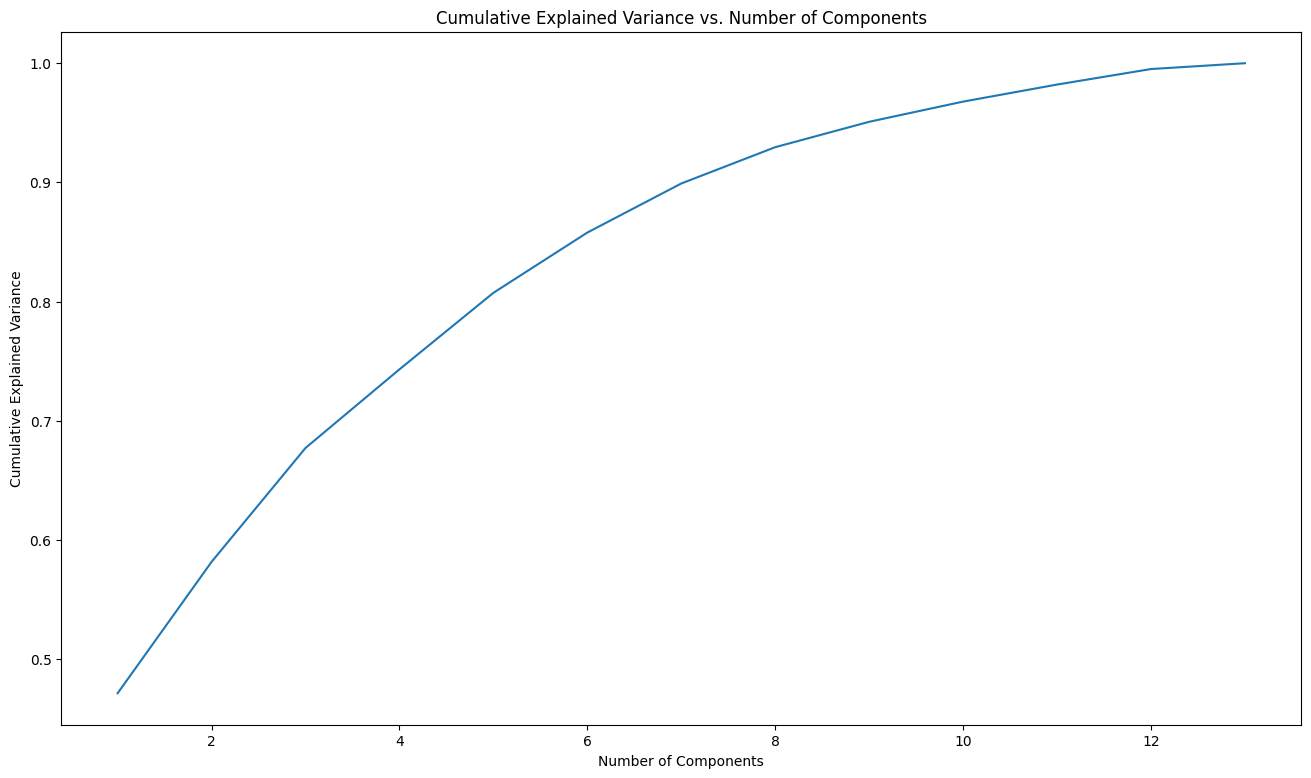

In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 定義特徵變數和目標變數
x = df.drop("X14", axis = 1)  # 定義房價以外為特徵變數
y = df["X14"]  # 定義房價為目標變數

# 標準化
scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns = x.columns, index=x.index)

# 使用 PCA 擬和
pca = PCA()
pca.fit(x_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# 繪製累積變異量
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, len(cumsum) + 1), cumsum)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs. Number of Components")
plt.show()

We use the Boston Housing dataset to predict the median house value (medv) based on 13 features.

Feature were standardised and reduced using PCA then next step is fed into random Forest Regressor.

This plot shows that PCA effectively reduced the dimensionality of the Boston Housing dataset from 13 features to 8 components while retaining 95% of the variance. The steep initial rise in the curve indicates strong correlations among features, and the choice of 8 components aligns with the 95% variance threshold you set.

In [55]:
pca = PCA(n_components = 0.95)
print(x_scaled.shape)
x_reduced = pd.DataFrame(pca.fit_transform(x_scaled), index = x.index)
print(x_reduced.shape)
print(pca.n_components_)

(506, 13)
(506, 9)
9


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

x_train_reduced = pd.DataFrame(pca.transform(x_train), index = x_train.index)  # 先降維 x_train
x_test_reduced = pd.DataFrame(pca.transform(x_test), index = x_test.index)

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(x_train_reduced, y_train)  # 用降維後的數據訓練
y_pred_rf = rf.predict(x_test_reduced)  # 預測降維後的 x_test

Target Variable: medv (median value of owner-occupied homes in $1000s).
Test Set: 20% of the data (based on your train_test_split with test_size=0.2).
Then fed the data into random forest regressor

    Feature  Importance
1        zn    0.298224
10  ptratio    0.283189
0      crim    0.263078
11        b    0.242150
5        rm    0.237159
8       rad    0.227493
3      chas    0.214682
12    lstat    0.208318
9       tax    0.199958
2     indus    0.192681
6       age    0.187925
7       dis    0.159647
4       nox    0.155475


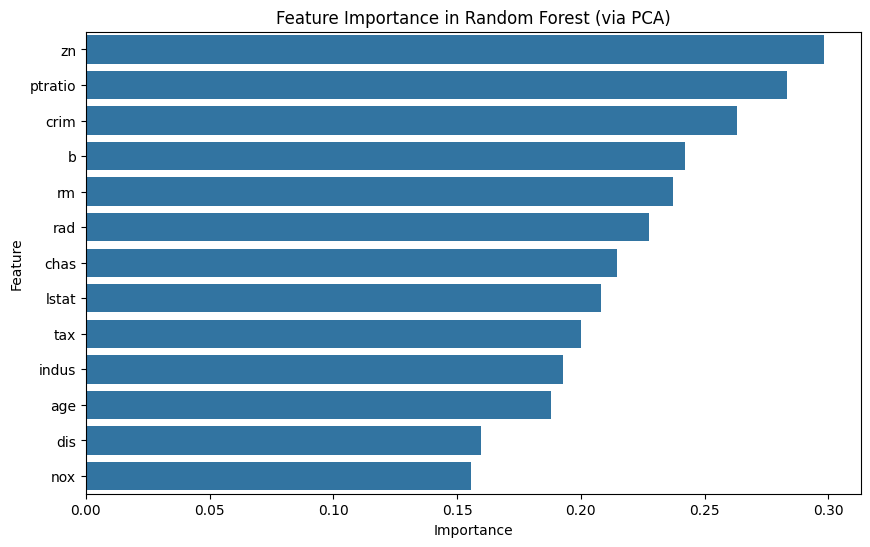

In [ ]:
import seaborn as sns
pca_components = pd.DataFrame(pca.components_, columns=x.columns)
feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Importance':np.abs(pca.components_).mean(axis=0) * rf.feature_importances_.sum()
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Random Forest (via PCA)')
plt.show()


This plot indicates that zn, ptratio, crim, b, and rm are the most influential features for predicting house prices in the Boston Housing dataset. These features likely contribute heavily to the principal components that explain the most variance

Features like nox, dis, and age play a smaller role


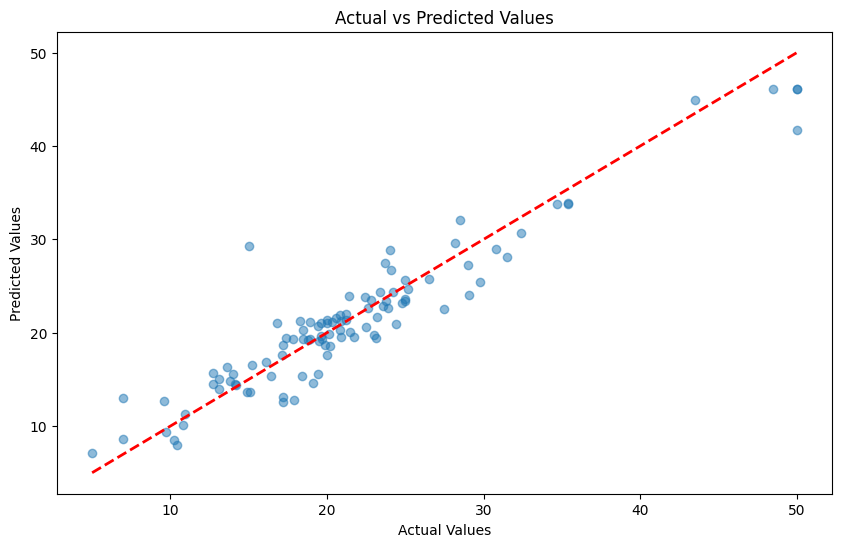

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Most points cluster around the red dashed line, indicating that the model’s predictions are generally close to the actual values. This aligns with the high R² score of 0.8923 fromevaluation metrics, which suggests the model explains 89.23% of the variance in medv.

The scatter plot shows that Random Forest model (with PCA) performs well overall, with most predictions closely aligned with actual values,

In [ ]:
from sklearn import metrics
from sklearn.metrics import r2_score
def time_series_evaluation_metrics_func(y_test, y_pred, print_flag=True):
    def mean_absolute_percentage_error(y_test, y_pred):
        y_true, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    def mean_squart_perdiction_error(y_test, y_pred):
        y_true, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(((y_test - y_pred))**2)

    print('Evaluation metric results:')
    print(f'MSE is : {metrics.mean_squared_error(y_test, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'MSPE:{mean_squart_perdiction_error(y_test, y_pred)}')
    print(f'sqrt MSPE:{np.sqrt(mean_squart_perdiction_error(y_test, y_pred))}')
    print(f'R2 is : {r2_score(y_test, y_pred)}', end='\n\n')
    return

time_series_evaluation_metrics_func(y_test, y_pred_rf)

Evaluation metric results:
MSE is : 7.901513892156864
MAE is : 2.0395392156862746
RMSE is : 2.8109631609391226
MAPE is : 11.092741558151904
MSPE:7.901513892156864
sqrt MSPE:2.8109631609391226
R2 is : 0.8922527442109116



An R² of 0.8923 means 89.23% of the variance in medv is explained by the model. This is excellent—close to 1 indicates a strong fit.

MAPE (11%) suggests predictions are typically within 11% of the true value.

---

